In [152]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
# from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
# from utils import preprocess, scale_value
import joblib

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [153]:
data = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [154]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [155]:
features = ['Close', 'Adj Close', 'Volume', 'Open']
df = data.dropna(subset=features)
X = data[features]

Text(0, 0.5, 'Close Price (USD)')

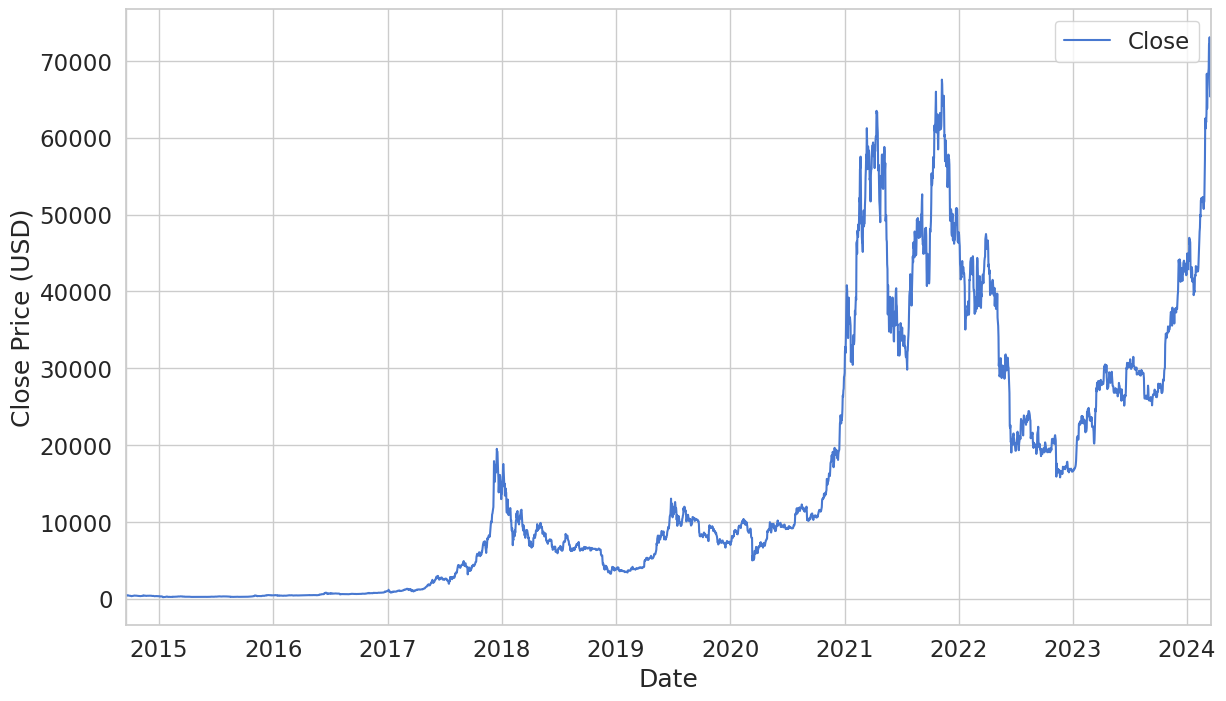

In [156]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [157]:
scaler = MinMaxScaler()

close_price = X.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)
X_normalized = scaler.fit_transform(X)
scaled_close.shape

(13880, 1)

In [158]:
X_normalized.shape

(3470, 4)

In [159]:
np.isnan(X_normalized).any()

False

In [160]:
print(X_normalized)
joblib.dump(scaler, 'scaler.gz')


[[3.83004592e-03 3.83004592e-03 4.31449241e-05 3.96374745e-03]
 [3.37885829e-03 3.37885829e-03 8.14009147e-05 3.84023959e-03]
 [2.97224900e-03 2.97224900e-03 9.11925723e-05 3.39091346e-03]
 ...
 [9.49527378e-01 9.49527378e-01 2.23142487e-01 9.76797771e-01]
 [8.93445710e-01 8.93445710e-01 1.33451143e-01 9.49427088e-01]
 [9.37904974e-01 9.37904974e-01 1.45306570e-01 8.92719321e-01]]


['scaler.gz']

PREPROCESSING

In [161]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(X_normalized, SEQ_LEN, train_split = 0.95)

In [162]:
y_train.shape

(3201, 4)

MODEL

In [163]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

/mnt/home/kvl16/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [164]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 347ms/step - loss: 0.0046 - val_loss: 0.0241
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 337ms/step - loss: 0.0042 - val_loss: 0.0188
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 325ms/step - loss: 0.0065 - val_loss: 0.0189
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - loss: 0.0058 - val_loss: 0.0192
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 307ms/step - loss: 0.0058 - val_loss: 0.0183
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 323ms/step - loss: 0.0069 - val_loss: 0.0188
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - loss: 0.0073 - val_loss: 0.0183
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 324ms/step - loss: 0.0067 - val_loss: 0.0176
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 324ms/step - loss: 0.0054 - val_loss: 0.0240
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - loss: 0.0035 - val_loss: 0.0374
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 323ms/step - loss: 0.0026 - val_loss: 0.0225
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20

In [165]:
model.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0441


0.06134176254272461

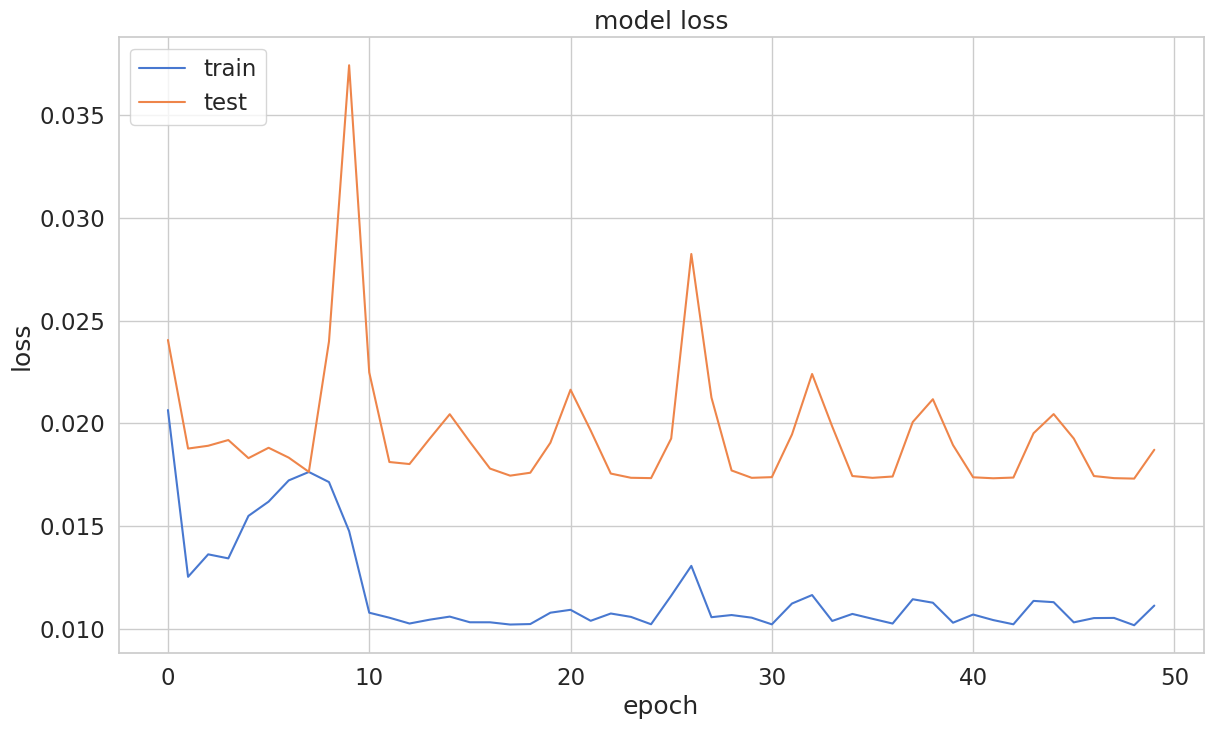

In [166]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [167]:
y_hat = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step


In [168]:
y_hat.shape

(169, 1)

In [169]:
y_test.shape

(169, 4)

In [183]:
print(y_train[:,0].shape)
print(y_test[:,0].shape)
print(y_hat[:,0].shape)

(3201,)
(169,)
(169,)


In [186]:
pastAndPresent = np.concatenate((y_train[:,0], y_test[:,0]), axis=0)
pastAndPredicted = np.concatenate((y_train[:,0], y_hat[:,0]), axis=0)

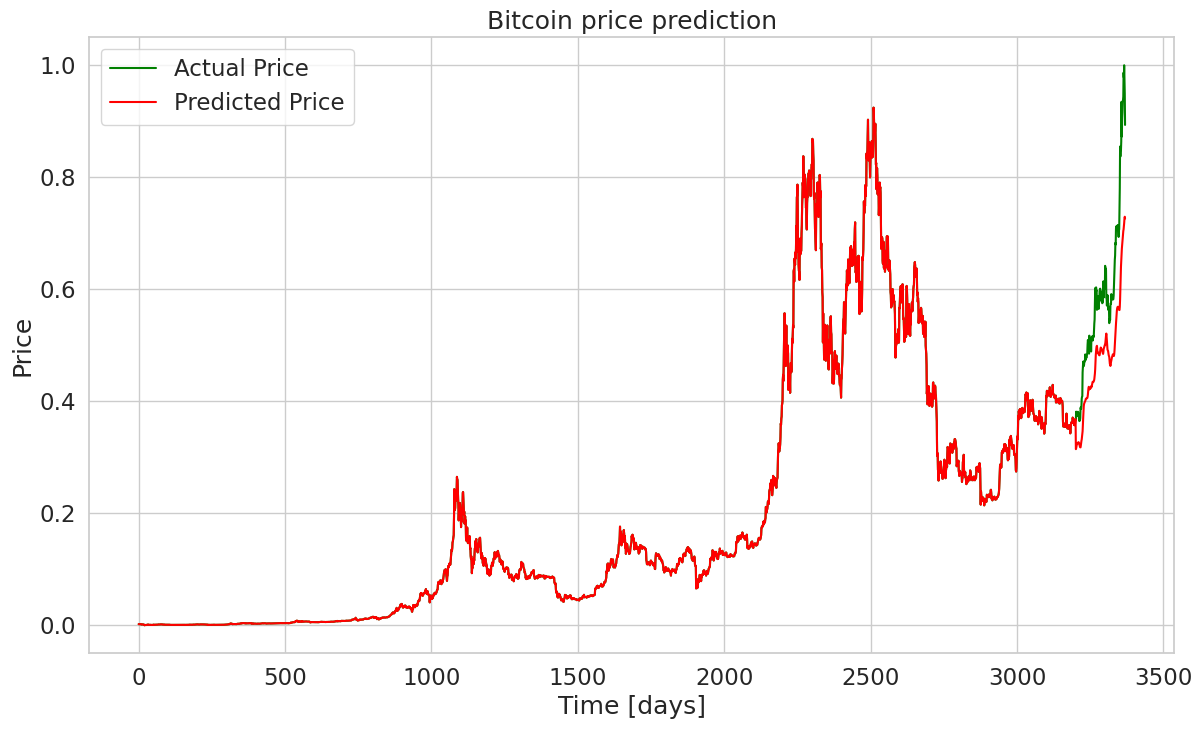

In [188]:
plt.plot(pastAndPresent, label="Actual Price", color='green')
plt.plot(pastAndPredicted, label="Predicted Price", color='red')
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

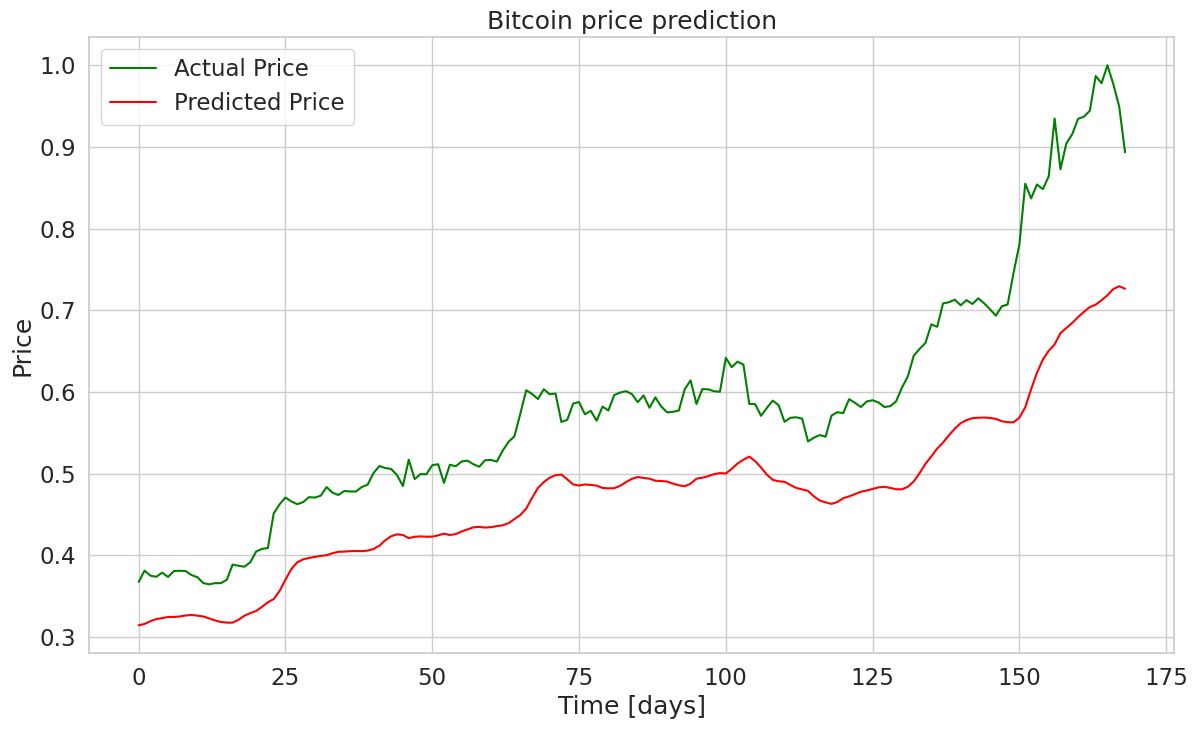

In [189]:
plt.plot(y_test[:,0], label="Actual Price", color='green')
plt.plot(y_hat, label="Predicted Price", color='red')
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

SAVE + DEPLOY

In [171]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_18                │ (None, 99, 198)        │        82,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 99, 198)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 99, 396)        │       628,848 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 99, 396)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 198)            │       392,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           199 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,312,743 (12.64 MB)

 Trainable params: 1,104,247 (4.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,208,496 (8.42 MB)

In [172]:
model.save('lstm.keras')

OSError: [Errno 95] Operation not supported

In [ ]:
print(X_test.shape)

(169, 99, 4)


In [ ]:
model.save(filepath='./1/', save_format='tf')

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

docker run -p 8501:8501 --name tfserving_classifier --mount type=bind,source=\Users\pda131212\Model\LSTM\1,target=/models/lstm -e MODEL_NAME=lstm -t tensorflow/serving